# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.listdir("/content/drive/MyDrive/real_vs_fake_human_faces")


['real_and_fake_face',
 'research.ipynb',
 'VGG_19_model.hdf5',
 'Resnet_50v2_model.h5',
 'Resnet_101v2_model.h5',
 'Inception_model.h5',
 'Resent50_model.h5']

In [3]:
import os
os.chdir("/content/drive/MyDrive/real_vs_fake_human_faces")
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow import keras


from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

Loading Libraries Done


# Data loading

In [4]:
# main_folder = "./rice_leaf_diseases/"
main_folder = "real_and_fake_face/"
RANDOM_SEED = 0

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))



['fake_face_images', 'real_face_image'] 2


In [5]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (192, 192,3)

def load_images_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        print(index, "folder name:",category)
        for image_name in tqdm(os.listdir(main_folder+"/"+category)):
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg"):
                #print(f"\nCategory = {category}, Image name = {image_name}")
                img = cv2.imread(main_folder+"/"+category+"/"+image_name)
                img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img_array = Image.fromarray(img, 'RGB')
                img_lst.append(np.array(img_array))
                labels.append(index)

    return img_lst, labels

images, labels = load_images_labels(categories)
print()
print("Total Images Loaded:", len(images))

0 folder name: fake_face_images


100%|██████████| 960/960 [00:14<00:00, 64.18it/s]


1 folder name: real_face_image


100%|██████████| 1081/1081 [00:17<00:00, 61.80it/s]


Total Images Loaded: 2041


In [6]:
images = np.array(images)
labels = np.array(labels)

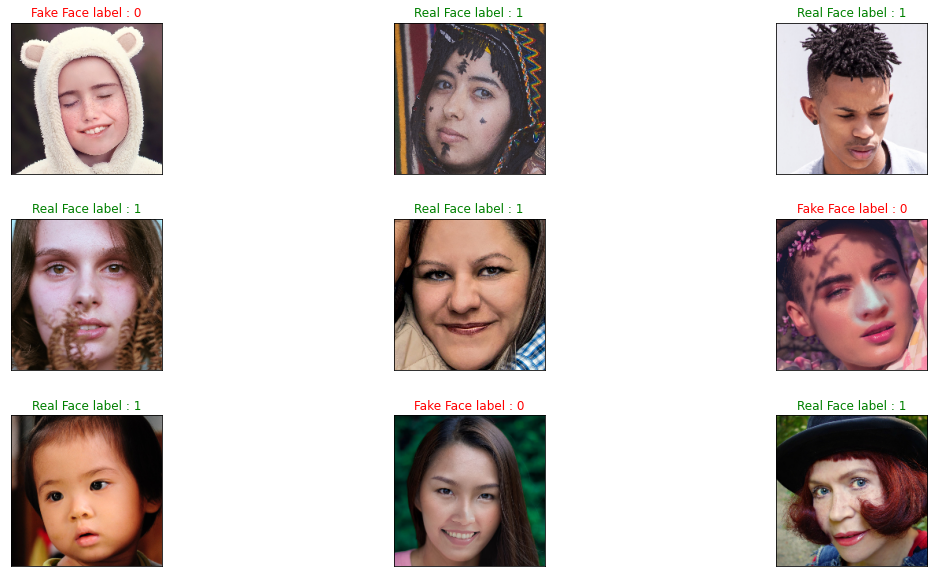

In [9]:
def display_random_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        if labels[r[0]]:
            plt.title('Real Face label : {}'.format(labels[r[0]]),color="g")
        else:
            plt.title('Fake Face label : {}'.format(labels[r[0]]),color="r")
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_random_images(images, labels)

In [10]:
np.random.seed(RANDOM_SEED)


n = np.arange(images.shape[0])
np.random.shuffle(n)

images = images[n]
labels = labels[n]

- Step 2 - Data normalization

In [11]:
images = images.astype(np.float32)
labels = labels.astype(np.int8)
images /= 255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (2041, 192, 192, 3)


- Display few random images after normalization

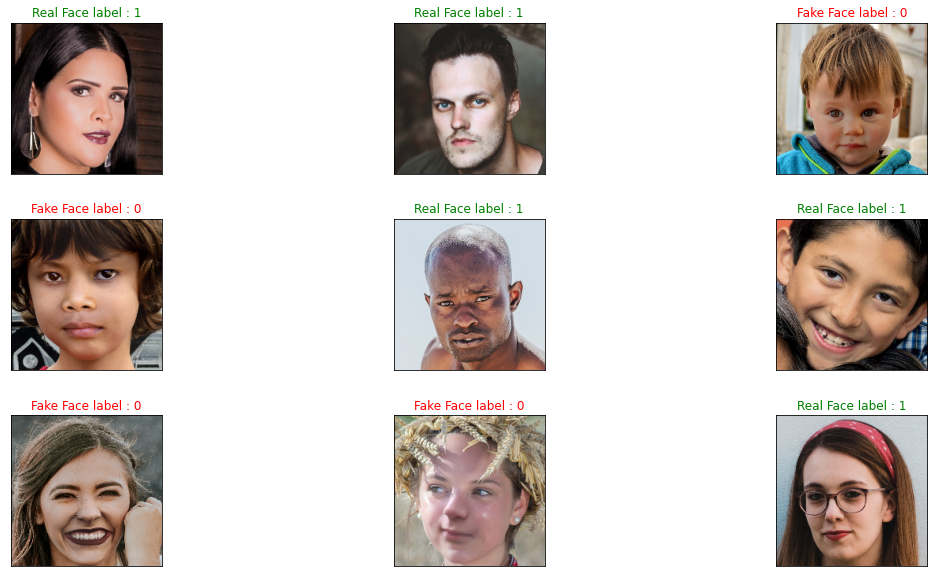

In [12]:
display_random_images(images, labels)

- Split dataset for training and testing

In [13]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.3, random_state = RANDOM_SEED)


print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (1428, 192, 192, 3)
y_train shape =  (1428,)

x_test shape =  (613, 192, 192, 3)
y_test shape =  (613,)


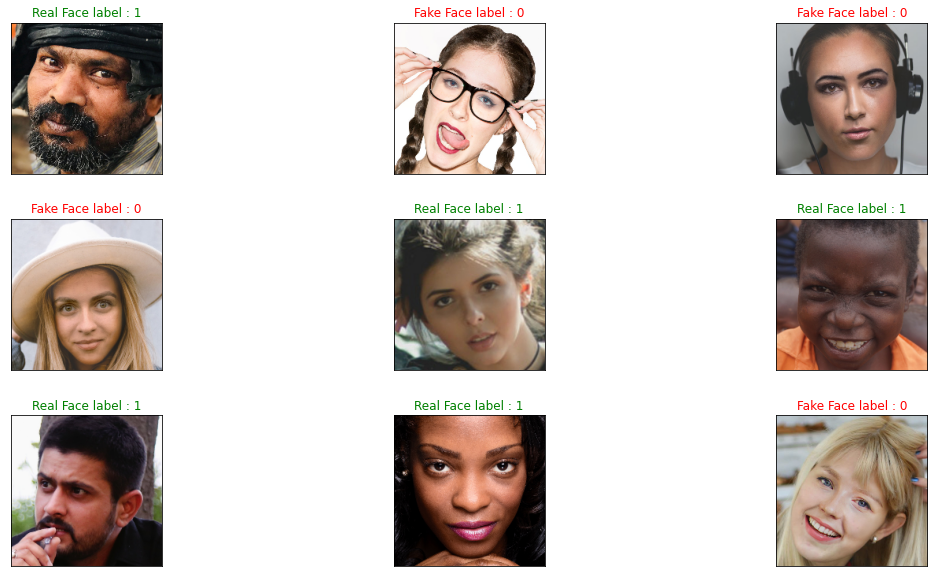

In [14]:
display_random_images(x_train, y_train)

In [15]:
EPOCHS = 30
BATCH_SIZE = 32

In [16]:
vgg = VGG19(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [17]:
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

In [18]:
x = Flatten()(vgg.output)
#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
vgg_model = Model(inputs=vgg.input, outputs=prediction)
vgg_model.summary()# view the structure of the model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 48, 48, 128)       0     

In [19]:
vgg_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [20]:
#Early stopping to avoid overfitting of model
early_stop = EarlyStopping(monitor='val_accuracy',mode='min', verbose=1, patience=15, restore_best_weights=True)
cback = ModelCheckpoint("VGG_19_model.hdf5",monitor='val_accuracy',save_best_only=True,verbose=1)

In [21]:
# fit the model
vgg_history = vgg_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[cback,early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 1.0729 - accuracy: 0.5291
Epoch 1: val_accuracy improved from -inf to 0.57237, saving model to VGG_19_model.hdf5
44/44 [==============================] - 20s 229ms/step - loss: 1.0729 - accuracy: 0.5291 - val_loss: 0.7599 - val_accuracy: 0.5724
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.6834
Epoch 2: val_accuracy improved from 0.57237 to 0.63158, saving model to VGG_19_model.hdf5
44/44 [==============================] - 10s 194ms/step - loss: 0.5989 - accuracy: 0.6834 - val_loss: 0.6867 - val_accuracy: 0.6316
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 0.4630 - accuracy: 0.7830
Epoch 3: val_accuracy did not improve from 0.63158
44/44 [==============================] - 8s 188ms/step - loss: 0.4630 - accuracy: 0.7830 - val_loss: 0.7114 - val_accuracy: 0.6234
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 0.4096 - accuracy: 0.8259
E

In [22]:
tf.keras.backend.clear_session()
vgg_loss, vgg_acc = vgg_model.evaluate(x_test,y_test,batch_size=32)
print("VGG 19 Loss:", vgg_loss)
print("VGG 19 Accuracy:", vgg_acc*100, "%")

20/20 [==============================] - 4s 183ms/step - loss: 0.7651 - accuracy: 0.5693
VGG 19 Loss: 0.7650907039642334
VGG 19 Accuracy: 56.9331169128418 %


In [23]:
best_vgg_model = load_model("VGG_19_model.hdf5")
vgg_loss, vgg_acc = best_vgg_model.evaluate(x_test,y_test,batch_size=32)
print("VGG 19 Loss:", vgg_loss)
print("VGG 19 Accuracy:", vgg_acc*100, "%")

20/20 [==============================] - 3s 138ms/step - loss: 0.7078 - accuracy: 0.6346
VGG 19 Loss: 0.7077562808990479
VGG 19 Accuracy: 63.45840096473694 %


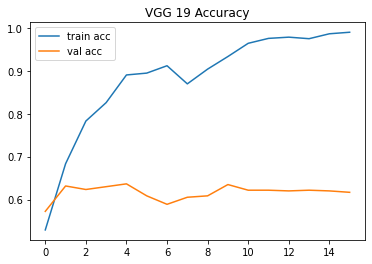

In [24]:
# accuracies
plt.plot(vgg_history.history['accuracy'], label='train acc')
plt.plot(vgg_history.history['val_accuracy'], label='val acc')
plt.title("VGG 19 Accuracy")
plt.legend()
plt.show()

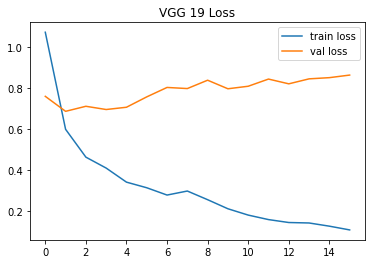

In [25]:
# loss
plt.plot(vgg_history.history['loss'], label='train loss')
plt.plot(vgg_history.history['val_loss'], label='val loss')
plt.title("VGG 19 Loss")
plt.legend()
plt.show()

In [26]:
#predict
y_pred = vgg_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
print(classification_report(y_pred,y_test))#get classification report

              precision    recall  f1-score   support

           0       0.90      0.52      0.66       496
           1       0.27      0.76      0.40       117

    accuracy                           0.57       613
   macro avg       0.59      0.64      0.53       613
weighted avg       0.78      0.57      0.61       613



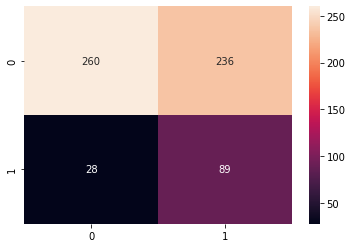

In [27]:
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True,fmt="d")
plt.show()

# RESNET 50 V2

In [28]:
resnet_50_v2 = ResNet50V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [29]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_50_v2.layers:
    layer.trainable = False

In [30]:
x = Flatten()(resnet_50_v2.output)

x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_v2_model = Model(inputs=resnet_50_v2.input, outputs=prediction)
# view the structure of the model
resnet_50_v2_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 98, 98, 64)   0           ['conv1_conv[0][0]']         

In [31]:
resnet_50_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

In [32]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_acc',mode='max', verbose=1, patience=15, restore_best_weights=True)
cback = ModelCheckpoint("Resnet_50v2_model.h5",monitor='val_acc',save_best_only=True,verbose=1)

In [33]:
# fit the model
resnet_50_v2_history = resnet_50_v2_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[cback,early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 0.9652 - acc: 0.5618
Epoch 1: val_acc improved from -inf to 0.57072, saving model to Resnet_50v2_model.h5
44/44 [==============================] - 12s 159ms/step - loss: 0.9652 - acc: 0.5618 - val_loss: 0.8938 - val_acc: 0.5707
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 0.7126 - acc: 0.6447
Epoch 2: val_acc improved from 0.57072 to 0.62829, saving model to Resnet_50v2_model.h5
44/44 [==============================] - 6s 129ms/step - loss: 0.7126 - acc: 0.6447 - val_loss: 0.7205 - val_acc: 0.6283
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 0.6251 - acc: 0.6948
Epoch 3: val_acc improved from 0.62829 to 0.68257, saving model to Resnet_50v2_model.h5
44/44 [==============================] - 6s 131ms/step - loss: 0.6251 - acc: 0.6948 - val_loss: 0.6644 - val_acc: 0.6826
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 0.4988 - acc: 0.7751
Epoch 4: val_acc di

In [34]:
resnet_50_v2_loss,resnet_50_v2_acc = resnet_50_v2_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50_V2 Loss:", resnet_50_v2_loss)
print("Resnet_50_V2 Accuracy:", resnet_50_v2_acc*100, "%")

20/20 [==============================] - 2s 97ms/step - loss: 0.6671 - acc: 0.6786
Resnet_50_V2 Loss: 0.6670907139778137
Resnet_50_V2 Accuracy: 67.86296963691711 %


In [35]:
best_resnet_50_v2_model = load_model("Resnet_50v2_model.h5")
resnet_50_v2_loss,resnet_50_v2_acc = best_resnet_50_v2_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50_V2 Loss:", resnet_50_v2_loss)
print("Resnet_50_V2 Accuracy:", resnet_50_v2_acc*100, "%")

20/20 [==============================] - 2s 68ms/step - loss: 0.6671 - acc: 0.6786
Resnet_50_V2 Loss: 0.6670907139778137
Resnet_50_V2 Accuracy: 67.86296963691711 %


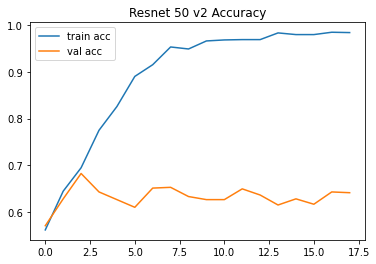

In [36]:
# accuracies
plt.plot(resnet_50_v2_history.history['acc'], label='train acc')
plt.plot(resnet_50_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 50 v2 Accuracy")
plt.legend()
plt.show()

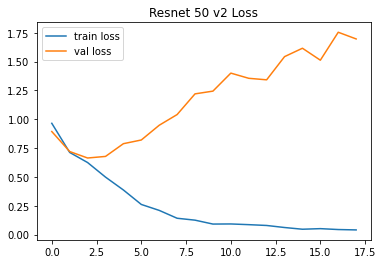

In [37]:
# loss
plt.plot(resnet_50_v2_history.history['loss'], label='train loss')
plt.plot(resnet_50_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 v2 Loss")
plt.legend()
plt.show()

In [38]:
#predict
y_pred=resnet_50_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.62      0.67      0.65       269
           1       0.73      0.69      0.71       344

    accuracy                           0.68       613
   macro avg       0.68      0.68      0.68       613
weighted avg       0.68      0.68      0.68       613



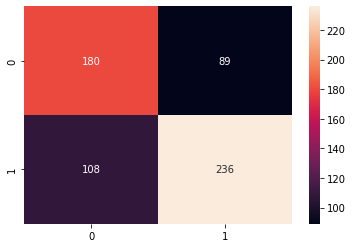

In [39]:
#get confusion matrix
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True,fmt="d")
plt.show()

# ResNet101V2

In [40]:
resnet_101_v2 = ResNet101V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [41]:
#do not train the pre-trained layers of VGG-19
for layer in resnet_101_v2.layers:
    layer.trainable = False

In [42]:
x = Flatten()(resnet_101_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)



#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_101_v2_model = Model(inputs=resnet_101_v2.input, outputs=prediction)
# view the structure of the model
resnet_101_v2_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 198, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 96, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 98, 98, 64)   0           ['conv1_conv[0][0]']       

In [43]:
resnet_101_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

In [44]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=5, restore_best_weights=True)
cback = ModelCheckpoint("Resnet_101v2_model.h5",monitor='val_acc',save_best_only=True,verbose=1)

In [45]:
# fit the model
resnet_101_v2_history = resnet_101_v2_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[cback,early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/30
44/44 [==============================] - ETA: 0s - loss: 0.9197 - acc: 0.5888
Epoch 1: val_acc improved from -inf to 0.62171, saving model to Resnet_101v2_model.h5
44/44 [==============================] - 19s 275ms/step - loss: 0.9197 - acc: 0.5888 - val_loss: 1.1310 - val_acc: 0.6217
Epoch 2/30
44/44 [==============================] - ETA: 0s - loss: 0.4185 - acc: 0.8159
Epoch 2: val_acc improved from 0.62171 to 0.64309, saving model to Resnet_101v2_model.h5
44/44 [==============================] - 10s 224ms/step - loss: 0.4185 - acc: 0.8159 - val_loss: 0.8609 - val_acc: 0.6431
Epoch 3/30
44/44 [==============================] - ETA: 0s - loss: 0.3028 - acc: 0.8832
Epoch 3: val_acc did not improve from 0.64309
44/44 [==============================] - 8s 183ms/step - loss: 0.3028 - acc: 0.8832 - val_loss: 0.8100 - val_acc: 0.6250
Epoch 4/30
44/44 [==============================] - ETA: 0s - loss: 0.1879 - acc: 0.9377
Epoch 4: val_acc did not improve from 0.64309
44/44 [=====

In [46]:
resnet_101_v2_loss,resnet_101_v2_acc = resnet_101_v2_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_101_V2 Loss:", resnet_101_v2_loss)
print("Resnet_101_V2 Accuracy:", resnet_101_v2_acc*100, "%")

20/20 [==============================] - 2s 116ms/step - loss: 0.8714 - acc: 0.6395
Resnet_101_V2 Loss: 0.8714436292648315
Resnet_101_V2 Accuracy: 63.94779682159424 %


In [47]:
best_resnet_101_v2_model = load_model("Resnet_101v2_model.h5")
resnet_101_v2_loss,resnet_101_v2_acc = best_resnet_101_v2_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_101_V2 Loss:", resnet_101_v2_loss)
print("Resnet_101_V2 Accuracy:", resnet_101_v2_acc*100, "%")

20/20 [==============================] - 4s 114ms/step - loss: 0.8714 - acc: 0.6395
Resnet_101_V2 Loss: 0.8714436292648315
Resnet_101_V2 Accuracy: 63.94779682159424 %


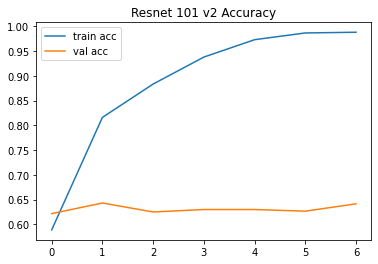

In [48]:
# accuracies
plt.plot(resnet_101_v2_history.history['acc'], label='train acc')
plt.plot(resnet_101_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 101 v2 Accuracy")
plt.legend()
plt.show()

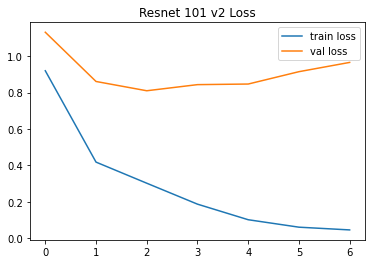

In [49]:
# loss
plt.plot(resnet_101_v2_history.history['loss'], label='train loss')
plt.plot(resnet_101_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 101 v2 Loss")
plt.legend()
plt.show()

In [50]:
#predict
y_pred=resnet_101_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       291
           1       0.66      0.66      0.66       322

    accuracy                           0.64       613
   macro avg       0.64      0.64      0.64       613
weighted avg       0.64      0.64      0.64       613



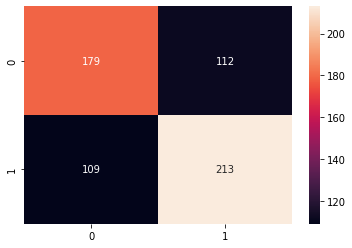

In [51]:
#get confusion matrix
sns.heatmap(confusion_matrix(y_pred,y_test),annot=True,fmt="d")
plt.show()